## Import MatPlotLib & Setup

In [1]:
# Setup plotting
import matplotlib.pyplot as plt
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

## Import Keras, Pandas & other used libraries

In [15]:
import pandas as pd
import numpy as np

import os
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

## Import Data

In [3]:
df_game_events = pd.read_csv("../data/game_events.csv")
game_events_features = ['timestamp', 'event_type', 'killer_id', 'killer_name', 'killer_team_id',]

df_game_metadata = pd.read_csv("../data/game_metadata.csv")
game_metadata_features = ['game_id']

df_game_players_stats = pd.read_csv("../data/game_players_stats.csv")
df_game_players_stats.head()

game_players_stats_features_num = ['game_length', 'champion_name', 'tower_kills', 'inhibitor_kills', 'dragon_kills', 'herald_kills', 'baron_kills', 
                               'player_kills', 'player_deaths', 'player_assists','total_minions_killed', 'gold_earned', 'level', 
                               'total_damage_dealt','total_damage_dealt_to_champions', 'total_damage_taken', 'wards_placed', 
                               'largest_killing_spree', 'largest_multi_kill']

game_players_stats_features_by_user_num = ['player_kills', 'player_deaths', 'player_assists', 'total_minions_killed', 'gold_earned', 'level', 
                                            'total_damage_dealt', 'total_damage_dealt_to_champions', 'total_damage_taken', 'wards_placed', 
                                            'largest_killing_spree', 'largest_multi_kill']
game_players_stats_features_by_user_cat = ['champion_name']

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
match_players = df_game_players_stats[df_game_players_stats['game_id'] == 0]
match_players.head(10)

,game_id,player_id,player_name,team_id,team_name,team_acronym,role,win,game_length,champion_name,team_kills,tower_kills,inhibitor_kills,dragon_kills,herald_kills,baron_kills,player_kills,player_deaths,player_assists,total_minions_killed,gold_earned,level,total_damage_dealt,total_damage_dealt_to_champions,total_damage_taken,wards_placed,largest_killing_spree,largest_multi_kill
30,0,21,Stark,4,Team Flash,TF,Top,True,2010,Renekton,22,10,1,2,1,2,4,4,9,275,14760,17,187887,12604,31066,18,2,1
31,0,22,Venus,5,Lowkey Esport Vietnam,LK,Support,False,2010,Nautilus,18,2,0,0,0,0,2,5,10,61,8188,13,23397,5298,12630,47,2,1
32,0,23,YiJin,4,Team Flash,TF,Jungle,True,2010,Sejuani,22,10,1,2,1,2,4,2,13,157,12963,16,165390,9776,38185,11,3,2
33,0,24,Celebrity,5,Lowkey Esport Vietnam,LK,Bot,False,2010,Ezreal,18,2,0,0,0,0,2,4,10,285,13108,16,197852,24770,13523,12,2,1
34,0,25,DNK,5,Lowkey Esport Vietnam,LK,Jungle,False,2010,Sylas,18,2,0,0,0,0,8,3,8,186,13850,16,169050,17982,27204,13,5,1
35,0,26,Artifact,5,Lowkey Esport Vietnam,LK,Mid,False,2010,Jayce,18,2,0,0,0,0,5,5,6,280,12926,17,171573,19579,15644,18,3,2
36,0,27,Hinn,4,Team Flash,TF,Support,True,2010,Morgana,22,10,1,2,1,2,1,4,16,15,8960,13,13032,4666,11567,59,0,1
37,0,28,Artemis,4,Team Flash,TF,Bot,True,2010,Lucian,22,10,1,2,1,2,9,6,7,289,15487,16,223488,20707,23348,11,4,2
38,0,29,Hani,5,Lowkey Esport Vietnam,LK,Top,False,2010,Kennen,18,2,0,0,0,0,1,5,5,229,11160,16,136281,10920,16643,13,0,1
39,0,30,C7N,4,Team Flash,TF,Mid,True,2010,Karma,22,10,1,2,1,2,4,2,11,303,15143,18,196700,14106,12036,15,2,2


## Import models & tools

In [4]:
import joblib

top_model = keras.models.load_model('role_models/top_model.keras')
jungle_model = keras.models.load_model('role_models/jungle_model.keras')
mid_model = keras.models.load_model('role_models/mid_model.keras')
sup_model = keras.models.load_model('role_models/sup_model.keras')
bot_model = keras.models.load_model('role_models/bot_model.keras')

models_by_role = {
    'Top': top_model,
    'Jungle': jungle_model,
    'Mid': mid_model,
    'Support': sup_model,
    'Bot': bot_model
}

win_loose_preprocessor = joblib.load('tools/win_loose_preprocessor.pkl')

## Import functions

In [5]:
def get_useful_players_data(dataframe : pd.DataFrame) -> pd.DataFrame:
    new_df = pd.DataFrame()
    
    new_df['KLA'] = (dataframe['player_kills'] + dataframe['player_assists']) / (dataframe['player_deaths'] + 1)
    new_df['gold_pm'] = dataframe['gold_earned'] / dataframe['game_length']
    new_df['lvl_pm'] = dataframe['level'] / dataframe['game_length']
    new_df['creep_score_pm'] = dataframe['total_minions_killed'] / dataframe['game_length']
    new_df['wards_pm'] = dataframe['wards_placed'] / dataframe['game_length']
    
    new_df['damage_pm'] = dataframe['total_damage_dealt'] / dataframe['game_length']
    new_df['damage_to_champions_pm'] = dataframe['total_damage_dealt_to_champions'] / dataframe['game_length']
    new_df['damage_taken_pm'] = dataframe['total_damage_taken'] / dataframe['game_length']
    
    new_df['greatest_killing_spree'] = dataframe['largest_killing_spree']
    new_df['greatest_multi_kill'] = dataframe['largest_multi_kill']
    
    return new_df

def get_solo_player_data(player_id : int, game_id : int) -> pd.DataFrame:
    """
    Get player data for a specific player and game.
    """
    # Filter by game_id first
    df_player = df_game_players_stats[df_game_players_stats['game_id'] == game_id]
    
    # Filter by player_id
    df_player = df_player[df_player['player_id'] == player_id]
    
    df_player_selected = get_useful_players_data(df_player)
    
    return df_player_selected

useful_player_columns_num = ['KLA', 'gold_pm', 'lvl_pm', 'creep_score_pm', 'wards_pm',
                            'damage_pm', 'damage_to_champions_pm', 'damage_taken_pm',
                            'greatest_killing_spree', 'greatest_multi_kill']

player_roles = ['Top', 'Jungle', 'Mid', 'Support', 'Bot']

def group_split(X: pd.DataFrame, y: pd.Series, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

def get_role_data(role: str, test_game_id: int | None = None) -> tuple:
    X = df_game_players_stats.loc[df_game_players_stats['role'] == role].copy()
    
    if test_game_id is not None:
        X = X.loc[X['game_id'] != test_game_id].copy()
    
    y = X['win'].copy()
    group = X['game_id'].copy()
    
    X = get_useful_players_data(X)
    
    X_train, X_valid, y_train, y_test = group_split(X, y, group)
    
    X_train = win_loose_preprocessor.fit_transform(X_train)
    X_valid = win_loose_preprocessor.transform(X_valid)
    
    return X_train, X_valid, y_train, y_test

## Compute Win probability for each player in each game

In [6]:
def compute_player_win_probabilities(df_players, models_by_role, batch_size=64):
    """
    Compute win probability for each player in each game using role-specific models.
    Optimized for speed with batched predictions.
    
    Args:
        df_players: DataFrame with player stats
        models_by_role: Dictionary of trained models for each role
        batch_size: Number of samples to process at once
    
    Returns:
        DataFrame with player IDs, game IDs, roles, and win probabilities
    """
    # Suppress TensorFlow logging and warnings
    import os
    import logging
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logging
    logging.getLogger('tensorflow').setLevel(logging.ERROR)
    
    # Dictionary to store predictions by role
    results = []
    role_groups = df_players.groupby('role')
    
    # Process one role at a time
    for role, role_df in role_groups:
        print(f"Processing role: {role}")
        
        if role not in models_by_role:
            continue
            
        model = models_by_role[role]
        
        # Group players by game to enable batch processing
        game_player_groups = role_df.groupby(['player_id', 'game_id'])
        
        # Collect all data for this role
        all_player_ids = []
        all_game_ids = []
        all_preprocessed_data = []
        all_wins = []
        
        for (player_id, game_id), player_data in game_player_groups:
            X_player = get_useful_players_data(player_data)
            X_player_preprocessed = win_loose_preprocessor.transform(X_player)
            
            all_player_ids.append(player_id)
            all_game_ids.append(game_id)
            all_preprocessed_data.append(X_player_preprocessed)
            all_wins.append(player_data['win'].iloc[0])
        
        # If no players for this role, continue
        if not all_preprocessed_data:
            continue
            
        # Convert to appropriate format for batch prediction
        X_batch = np.vstack(all_preprocessed_data)
        
        # Make predictions in batch (much faster!)
        print(f"Processing {len(X_batch)} predictions for role: {role}")
        win_probabilities = model.predict(X_batch, batch_size=batch_size, verbose=0).flatten()
        
        # Store results
        for i in range(len(all_player_ids)):
            results.append({
                'player_id': all_player_ids[i],
                'game_id': all_game_ids[i],
                'role': role,
                'win_probability': win_probabilities[i],
                'actual_outcome': all_wins[i]
            })
    
    return pd.DataFrame(results)

## Compute performance metrics & Normalize them

In [7]:
def calculate_player_performance_metrics(win_probabilities_df):
    """
    Calculate performance metrics for each player across all games.
    
    Args:
        win_probabilities_df: DataFrame with win probabilities
    
    Returns:
        DataFrame with player performance metrics
    """
    # Group by player_id
    player_metrics = []
    
    for player_id, player_games in win_probabilities_df.groupby('player_id'):
        # Calculate metrics
        avg_win_probability = player_games['win_probability'].mean()
        num_games = len(player_games)
        actual_win_rate = player_games['actual_outcome'].mean()
        
        # Calculate "impact score" - how much better the player performs than predicted
        # This could be a measure of clutch performance or consistency
        impact_score = actual_win_rate - avg_win_probability
        
        # Calculate variance in performance
        win_prob_variance = player_games['win_probability'].var()
        
        # Store metrics
        player_metrics.append({
            'player_id': player_id,
            'role': player_games['role'].iloc[0],  # Assuming player always plays same role
            'num_games': num_games,
            'avg_win_probability': avg_win_probability,
            'actual_win_rate': actual_win_rate,
            'impact_score': impact_score,
            'performance_consistency': 1 - win_prob_variance  # Higher is more consistent
        })
    
    return pd.DataFrame(player_metrics)

def normalize_performance_by_role(player_metrics_df):
    """
    Transform performance metrics to percentiles within each role.
    
    Args:
        player_metrics_df: DataFrame with player performance metrics
    
    Returns:
        DataFrame with normalized performance metrics
    """
    normalized_df = player_metrics_df.copy()
    
    # List of metrics to normalize
    metrics_to_normalize = [
        'avg_win_probability', 
        'impact_score', 
        'performance_consistency'
    ]
    
    # Normalize each metric within role
    for role in player_metrics_df['role'].unique():
        role_mask = normalized_df['role'] == role
        role_df = normalized_df[role_mask]
        
        for metric in metrics_to_normalize:
            # Calculate percentile rank for this metric within this role
            percentile_values = role_df[metric].rank(pct=True)
            
            # Update normalized DataFrame
            normalized_df.loc[role_mask, f'{metric}_percentile'] = percentile_values
    
    return normalized_df

## Compute Skill rank

In [8]:
def compute_skill_rank(normalized_metrics_df, weights=None):
    """
    Compute overall skill rank by combining normalized metrics.
    
    Args:
        normalized_metrics_df: DataFrame with normalized metrics
        weights: Optional dictionary of weights for each metric
    
    Returns:
        DataFrame with player skills and ranks
    """
    if weights is None:
        # Default weights - you can adjust these
        weights = {
            'avg_win_probability_percentile': 0.5,  # Higher weight on win probability
            'impact_score_percentile': 0.3,         # Medium weight on impact 
            'performance_consistency_percentile': 0.2  # Lower weight on consistency
        }
    
    skill_df = normalized_metrics_df.copy()
    
    # Calculate weighted score
    skill_df['skill_score'] = 0
    
    for metric, weight in weights.items():
        skill_df['skill_score'] += skill_df[metric] * weight
    
    # Calculate overall rank
    skill_df['skill_rank'] = skill_df['skill_score'].rank(ascending=False)
    
    return skill_df.sort_values('skill_rank')

## Generate win probabilities

In [ ]:
# Generate win probabilities with a larger batch size for speed
# print("Starting win probability calculations...")
# df_win_probs = compute_player_win_probabilities(df_game_players_stats, models_by_role, batch_size=15000)
# print(f"Finished processing {len(df_win_probs)} player predictions")

Starting win probability calculations...
Processing role: Bot
Processing 74908 predictions for role: Bot
Processing role: Jungle
Processing 74912 predictions for role: Jungle
Processing role: Mid
Processing 74912 predictions for role: Mid
Processing role: Support
Processing 74910 predictions for role: Support
Processing role: Top
Processing 74912 predictions for role: Top
Finished processing 374554 player predictions


## Save probabilities

In [16]:

def save_proba():
    os.makedirs('computed_dataframe/', exist_ok=True)
    df_win_probs.to_csv('computed_dataframe/win_probabilities.csv', index=False)
    
save_proba()

## Import CSV already computed (18min with RTX 3060)

In [ ]:
df_win_probs = pd.read_csv('computed_dataframe/win_probabilities.csv')

## Generate performance

In [10]:
df_performance_metrics = calculate_player_performance_metrics(df_win_probs)

df_normalized_metrics = normalize_performance_by_role(df_performance_metrics)

## Generate Skill rankings

In [13]:

skill_rankings = compute_skill_rank(df_normalized_metrics)

player_names = df_game_players_stats[['player_id', 'player_name']].drop_duplicates()
skill_rankings = skill_rankings.merge(player_names, on='player_id')
    
skill_rankings[['player_id', 'player_name', 'role', 'skill_score', 
                'skill_rank', 'num_games', 'avg_win_probability', 
                'actual_win_rate', 'impact_score']].head(10)

,player_id,player_name,role,skill_score,skill_rank,num_games,avg_win_probability,actual_win_rate,impact_score
0,4738,Time,Jungle,0.967081,1.0,2,0.700884,1.000000,0.299116
1,4904,Maxou,Jungle,0.963156,2.0,6,0.759814,1.000000,0.240186
2,4934,IWANAN3,Mid,0.960553,3.0,3,0.732497,1.000000,0.267503
3,4900,Cristal,Mid,0.956559,4.0,5,0.852105,1.000000,0.147895
4,3850,Xpontaneous,Bot,0.953098,5.0,17,0.844293,0.941176,0.096883
5,2906,Inferiorities,Top,0.950479,6.0,2,0.802624,1.000000,0.197376
6,2269,Paladin,Bot,0.939486,7.0,15,0.784911,0.866667,0.081756
7,3146,Daiky,Jungle,0.938151,8.0,3,0.618575,1.000000,0.381425
8,1670,Sky,Mid,0.931671,9.0,6,0.789640,1.000000,0.210360
9,4905,Druust,Mid,0.926666,10.0,6,0.921954,1.000000,0.078046


## Visualize skill rankings

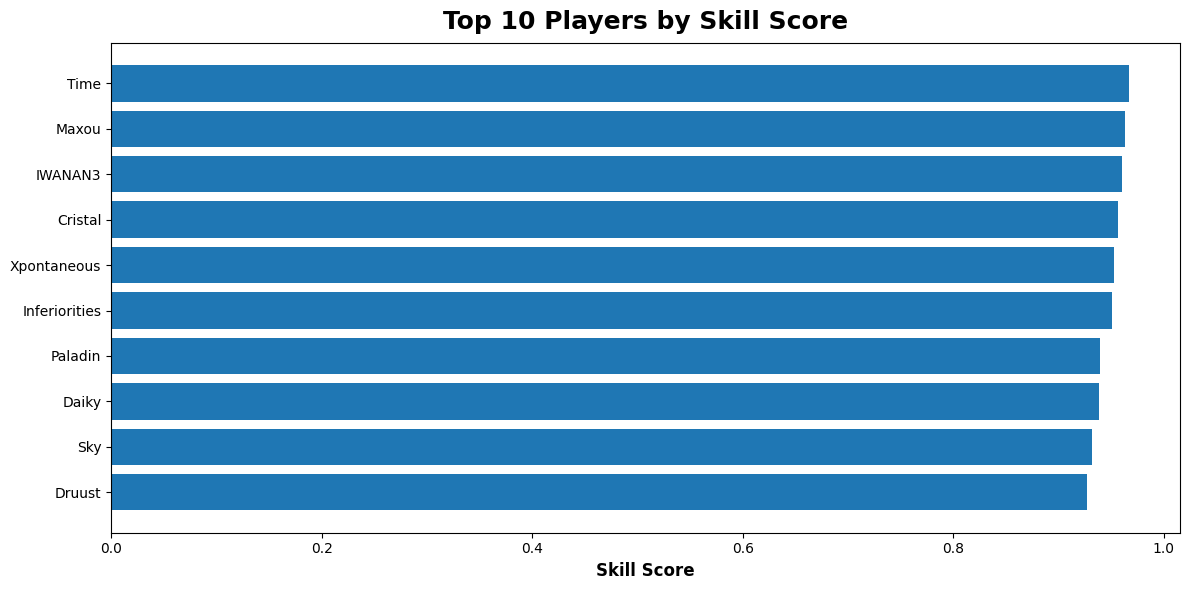

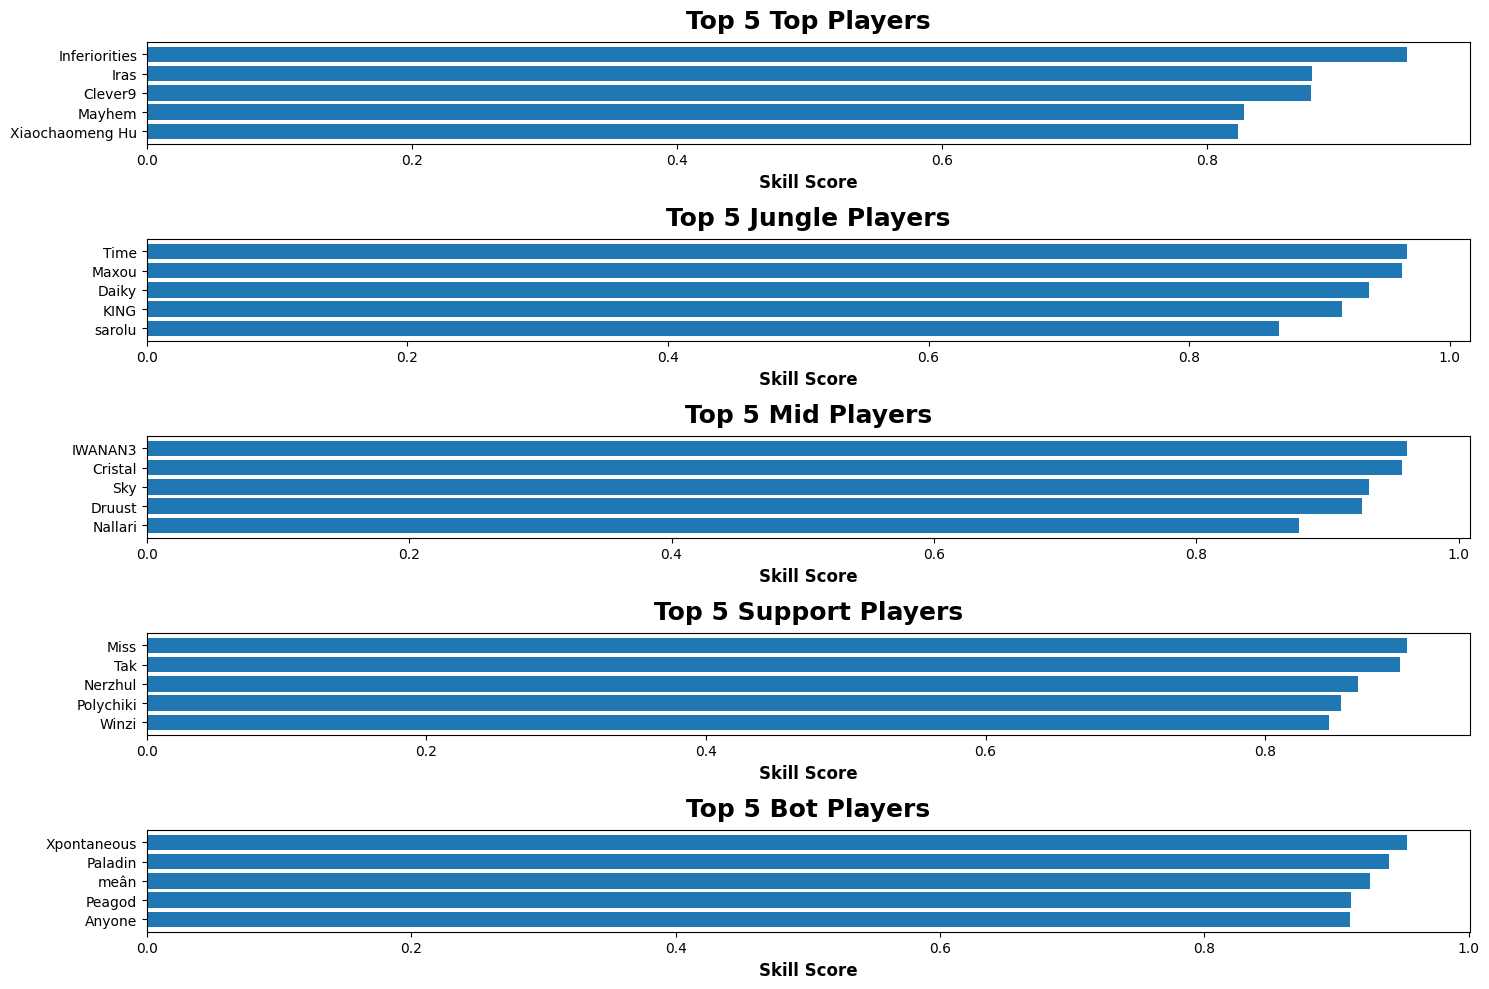

In [12]:
    
def visualize_player_rankings(skill_rankings):
    """
    Create visualizations of player rankings.
    """
    # Top players overall
    top_players = skill_rankings.sort_values('skill_score', ascending=False).head(10)
    
    plt.figure(figsize=(12, 6))
    plt.barh(top_players['player_name'], top_players['skill_score'])
    plt.xlabel('Skill Score')
    plt.title('Top 10 Players by Skill Score')
    plt.gca().invert_yaxis()  # Highest at the top
    plt.tight_layout()
    plt.show()
    
    # Top players by role
    plt.figure(figsize=(15, 10))
    
    for i, role in enumerate(player_roles, 1):
        role_players = skill_rankings[skill_rankings['role'] == role]
        top_role_players = role_players.sort_values('skill_score', ascending=False).head(5)
        
        plt.subplot(len(player_roles), 1, i)
        plt.barh(top_role_players['player_name'], top_role_players['skill_score'])
        plt.xlabel('Skill Score')
        plt.title(f'Top 5 {role} Players')
        plt.gca().invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
visualize_player_rankings(skill_rankings)